In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np

from astropy.io import fits
from astropy.table import Table, Column
from astropy.utils.data import download_file, clear_download_cache

from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model

import matplotlib.pyplot as plt
from matplotlib import colors

from kungpao.display import display_single

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Download the test data

In [2]:
url = 'https://github.com/astropy/photutils-datasets/raw/master/data/isophote/M51.fits'
path = download_file(url)
hdu = fits.open(path)
data = hdu[0].data
hdu.close()

#### Test interpolation and model building

In [3]:
ellipse = Ellipse(data)

isolist = ellipse.fit_image(sclip=2., nclip=3)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Current model building time
%time model_image = build_ellipse_model(data.shape, isolist, fill=np.mean(data[0:10, 0:10]))

CPU times: user 5.42 s, sys: 23.8 ms, total: 5.44 s
Wall time: 5.46 s


In [48]:
%time model_image = build_ellipse_model(data.shape, isolist, fill=np.mean(data[0:10, 0:10]), high_harmonics=False)

CPU times: user 5.57 s, sys: 27.2 ms, total: 5.59 s
Wall time: 5.63 s


##### Interpolation test

In [49]:
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import interp1d

In [35]:
finely_spaced_sma = np.arange(isolist[0].sma, isolist[-1].sma, 0.1)

nodes = isolist.sma[2:-2]

In [25]:
%timeit intens_array = LSQUnivariateSpline(isolist.sma, isolist.intens, nodes, k=3)(finely_spaced_sma)

135 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [51]:
%timeit interp1d(isolist.sma, isolist.intens, kind='linear')(finely_spaced_sma)

102 µs ± 2.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [69]:
%timeit interp1d(isolist.sma, isolist.intens, kind='quadratic')(finely_spaced_sma)

319 µs ± 5.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
intens_array = LSQUnivariateSpline(
    isolist.sma, isolist.intens, nodes, k=3)(finely_spaced_sma)

log10_intens_array = LSQUnivariateSpline(
        isolist.sma, np.log10(isolist.intens), nodes, k=3)(finely_spaced_sma)

In [64]:
intens_linear = interp1d(isolist.sma, isolist.intens, kind='linear')(finely_spaced_sma)
intens_slinear = interp1d(isolist.sma, isolist.intens, kind='slinear')(finely_spaced_sma)
intens_quad = interp1d(isolist.sma, isolist.intens, kind='quadratic')(finely_spaced_sma)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


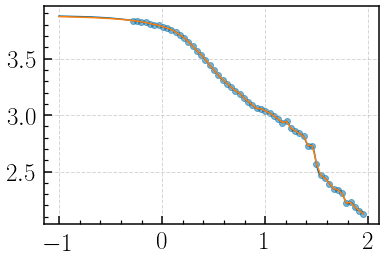

In [65]:
plt.scatter(np.log10(isolist.sma), np.log10(isolist.intens), alpha=0.5)
plt.plot(np.log10(finely_spaced_sma), np.log10(intens_array))
plt.plot(np.log10(finely_spaced_sma), np.log10(intens_linear))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


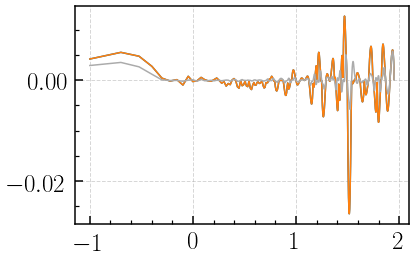

In [68]:
plt.plot(np.log10(finely_spaced_sma), np.log10(intens_array) - np.log10(intens_linear))
plt.plot(np.log10(finely_spaced_sma), np.log10(intens_array) - np.log10(intens_slinear))
plt.plot(np.log10(finely_spaced_sma), np.log10(intens_array) - np.log10(intens_quad))